In [1]:
from pathlib import Path

dataset_path = Path(r'/home/thor/Desktop/datasets/emoji-hero')
training_set_path = dataset_path / 'training_set'
validation_set_path = dataset_path / 'validation_set'
test_set_path = dataset_path / 'test_set'

id_to_emotion = {
    0: 'Neutral',
    1: 'Happy',
    2: 'Sad',
    3: 'Surprise',
    4: 'Fear',
    5: 'Disgust',
    6: 'Anger',
}


In [2]:
def compute_class_frequencies(dataset_path: Path) -> dict:
    class_frequencies = {}
    for class_dir in sorted(dataset_path.iterdir()):
        num_files = sum(1 for _ in class_dir.iterdir())
        class_id = int(class_dir.name)
        class_frequencies[class_id] = num_files
        print(f'{class_id} - {id_to_emotion[class_id]:<9} : {num_files:>8} images')

    return class_frequencies


In [3]:
from tensorflow.keras.models import load_model

model = load_model(
    r'/home/thor/Desktop/repos/emoji-hero-baseline/affectnet_transfer_imagenet_complete_unfreeze_checkpoints_20240319-2236/best_model_phase_2.keras')

2024-03-20 14:27:17.949669: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 14:27:17.970003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 14:27:17.970023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 14:27:17.970530: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 14:27:17.973965: I tensorflow/core/platform/cpu_feature_guar

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SEED = 42


In [5]:
from tensorflow import keras

print('\n---TRAINING SET---')
training_set = keras.preprocessing.image_dataset_from_directory(training_set_path,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=False)
compute_class_frequencies(training_set_path)

print('\n---VALIDATION SET---')
validation_set = keras.preprocessing.image_dataset_from_directory(validation_set_path,
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMAGE_SIZE,
                                                                  shuffle=False)
compute_class_frequencies(validation_set_path)

print('\n---TEST SET---')
test_set = keras.preprocessing.image_dataset_from_directory(test_set_path,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE,
                                                            shuffle=False)
compute_class_frequencies(test_set_path)



---TRAINING SET---
Found 2030 files belonging to 7 classes.
0 - Neutral   :      414 images
1 - Happy     :      400 images
2 - Sad       :      274 images
3 - Surprise  :      360 images
4 - Fear      :      220 images
5 - Disgust   :      212 images
6 - Anger     :      150 images

---VALIDATION SET---
Found 770 files belonging to 7 classes.
0 - Neutral   :      110 images
1 - Happy     :      110 images
2 - Sad       :      110 images
3 - Surprise  :      110 images
4 - Fear      :      110 images
5 - Disgust   :      110 images
6 - Anger     :      110 images

---TEST SET---
Found 756 files belonging to 7 classes.
0 - Neutral   :      108 images
1 - Happy     :      108 images
2 - Sad       :      108 images
3 - Surprise  :      108 images
4 - Fear      :      108 images
5 - Disgust   :      108 images
6 - Anger     :      108 images


{0: 108, 1: 108, 2: 108, 3: 108, 4: 108, 5: 108, 6: 108}

In [6]:
train_loss, train_acc = model.evaluate(training_set)
print(f"TRAINING accuracy: {train_acc}")

2024-03-20 14:27:32.059146: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-20 14:27:32.272501: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-20 14:27:32.314848: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


64/64 [==============================] - 4s 30ms/step - loss: 1.7381 - accuracy: 0.4128
TRAINING accuracy: 0.4128078818321228


In [7]:
val_loss, val_acc = model.evaluate(validation_set)
print(f"VALIDATION accuracy: {val_acc}")

25/25 [==============================] - 1s 25ms/step - loss: 2.0188 - accuracy: 0.3338
VALIDATION accuracy: 0.33376622200012207


In [8]:
test_loss, test_acc = model.evaluate(test_set)
print(f"TEST accuracy: {test_acc}")

24/24 [==============================] - 1s 25ms/step - loss: 1.9243 - accuracy: 0.3757
TEST accuracy: 0.37566137313842773


In [9]:
combined_set = validation_set.concatenate(test_set)

In [10]:
total_loss, total_acc = model.evaluate(combined_set)
print(f"TOTAL accuracy: {total_acc}")

49/49 [==============================] - 1s 25ms/step - loss: 1.9720 - accuracy: 0.3545
TOTAL accuracy: 0.35452163219451904


In [11]:
import numpy as np
from sklearn.metrics import classification_report

y_pred_vectors = model.predict(combined_set)
y_pred = np.argmax(y_pred_vectors, axis=1)
y_true = np.concatenate([y for _, y in combined_set], axis=0)

report = classification_report(y_true, y_pred, target_names=id_to_emotion.values(), digits=4)
print(report)

49/49 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

     Neutral     0.2390    0.6697    0.3522       218
       Happy     0.7252    0.4358    0.5444       218
         Sad     0.5200    0.1789    0.2662       218
    Surprise     0.4301    0.9174    0.5857       218
        Fear     0.1333    0.0092    0.0172       218
     Disgust     0.3134    0.1927    0.2386       218
       Anger     0.1789    0.0780    0.1086       218

    accuracy                         0.3545      1526
   macro avg     0.3629    0.3545    0.3018      1526
weighted avg     0.3629    0.3545    0.3018      1526


[[146   1  11  15   0  11  34]
 [ 62  95   1  28   2  27   3]
 [ 98   3  39  32   0  13  33]
 [ 10   2   0 200   0   6   0]
 [ 91   5   7  83   2  28   2]
 [ 94   8   8  58   2  42   6]
 [110  17   9  49   9   7  17]]


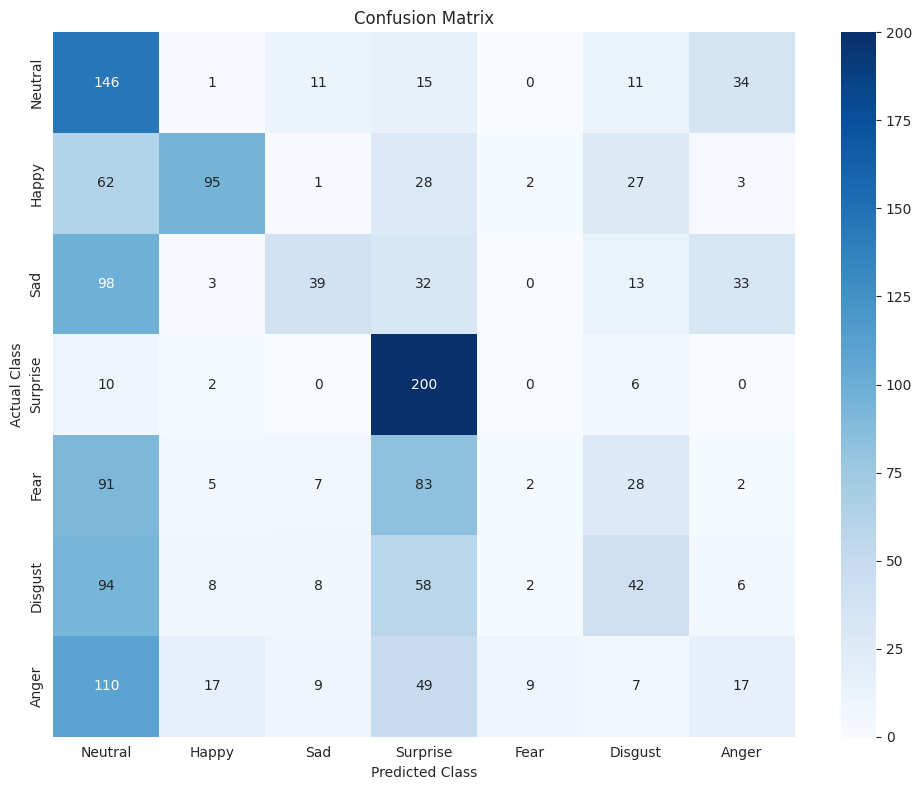

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    class_names = id_to_emotion.values()

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.tight_layout()
    plt.show()

    return fig


cm_figure = plot_confusion_matrix(y_true, y_pred)


In [13]:
result_dir = Path('cross_validation_affectnet_emoji_hero')
result_dir.mkdir(exist_ok=True)


def save_evaluation_results(report, cm_figure, checkpoint_dir):
    with (checkpoint_dir / 'classification_report.txt').open(mode='w') as f:
        f.write(report)
    cm_figure.savefig(str(checkpoint_dir / 'confusion_matrix.png'))


save_evaluation_results(report, cm_figure, result_dir)

In [14]:
import shutil

path_to_this_notebook = Path(
    '/home/thor/Desktop/repos/emoji-hero-baseline/emojihero_cross_affectnet.ipynb')

shutil.copy2(path_to_this_notebook, (result_dir / path_to_this_notebook.name))

PosixPath('cross_validation_affectnet_emoji_hero/emojihero_cross_affectnet.ipynb')